# Basic Configs
- references: 
    - https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
    - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    - https://github.com/kuangliu/pytorch-cifar

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt

## Global Variables

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

## Load Data

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='./data', train=True, 
                            download=True, transform=transform_train)
trainloader = data.DataLoader(trainset, batch_size=4, 
                              shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, 
                           download=True, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=1, 
                             shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("train set length = ", len(trainset))
print("test set length = ", len(testset))

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
train set length =  50000
test set length =  10000


# Model
- From https://github.com/kuangliu/pytorch-cifar

In [5]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

# Train

## Save and Load Model

In [19]:
from datetime import datetime

def save_model(model, epoch, optimizer, scheduler):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict' : scheduler.state_dict(),
    }, "gdrive/My Drive/18-786 IDL/Project/defense/"+"Model_"+str(datetime.now())+'_'+str(epoch)+'.pth')

In [7]:
def load_model(model, optimizer, scheduler, file_name):
    temp = torch.load(file_name) 
    model.load_state_dict(temp['model_state_dict'])
    optimizer.load_state_dict(temp['optimizer_state_dict'])
    scheduler.load_state_dict(temp['scheduler_state_dict'])

## Train Function

In [25]:
import time

def train_epoch(model, epoch, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    epoch_loss = 0.0
    correct = 0
    start_time = time.time()
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == y).sum().item()

        loss.backward()
        optimizer.step()

        # print every 2000 mini-batches
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
            epoch_loss += running_loss
            running_loss = 0.0

    end_time = time.time()
    total = len(train_loader.dataset)
    epoch_loss = (epoch_loss + running_loss) / total
    print('At epoch', epoch, 'Training Loss: ', epoch_loss, 'Time: ',
          end_time - start_time, 's')
    print('Accuracy of the network on the %d train images: %d %%' % (
            total, 100.0 * correct / total))
    return running_loss, correct / total

## Eval Function

In [24]:
def eval_epoch(model, test_loader, criterion, get_pred=False):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        correct_predictions = 0.0
        pred = []

        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)

            output = model(x)

            _, predicted = torch.max(output.data, 1)
            correct_predictions += (predicted == y).sum().item()

            loss = criterion(output, y).detach()
            running_loss += loss.item()

            if get_pred:
                pred.append(predicted.detach().cpu().numpy())

        total = len(test_loader.dataset)
        running_loss /= total
        acc = (correct_predictions/total)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        if get_pred:
            pred = np.concatenate(pred)
            return running_loss, acc, pred
        else:
            return running_loss, acc

## Define the Loss Function and Optimizer

In [8]:
net = VGG('VGG16').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

## Train

In [ ]:
def train(net, criterion, optimizer, scheduler, trainloader, testloader, num_epoches):
    for epoch in range(num_epoches):  # loop over the dataset multiple times
        train_loss, train_accuracy = train_epoch(net, epoch, trainloader, criterion, optimizer)
        test_loss, test_accuracy = eval_epoch(net, testloader, criterion)
        scheduler.step(test_loss)
        save_model(net, epoch, optimizer, scheduler)

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, scheduler, trainloader, testloader, 70)

[1,  2000] loss: 2.028
[1,  4000] loss: 1.830
[1,  6000] loss: 1.689
[1,  8000] loss: 1.519
[1, 10000] loss: 1.408
[1, 12000] loss: 1.307
At epoch 0 Training Loss:  0.012229918670654297 Time:  227.29679703712463 s
Accuracy of the network on the 50000 train images: 42 %
Testing Loss:  1.1443783657089808
Testing Accuracy:  58.91 %
[2,  2000] loss: 1.183
[2,  4000] loss: 1.122
[2,  6000] loss: 1.076
[2,  8000] loss: 1.056
[2, 10000] loss: 1.002
[2, 12000] loss: 0.968
At epoch 1 Training Loss:  0.010055217841118574 Time:  222.05571794509888 s
Accuracy of the network on the 50000 train images: 62 %
Testing Loss:  0.8801122333146398
Testing Accuracy:  71.19 %
[3,  2000] loss: 0.889
[3,  4000] loss: 0.895
[3,  6000] loss: 0.885
[3,  8000] loss: 0.850
[3, 10000] loss: 0.822
[3, 12000] loss: 0.797
At epoch 2 Training Loss:  0.007708403342217207 Time:  219.53972554206848 s
Accuracy of the network on the 50000 train images: 71 %
Testing Loss:  0.7152572934161817
Testing Accuracy:  75.79 %
[4,  20

KeyboardInterrupt: ignored

# Attack

In [9]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image
    return perturbed_image

## Test

In [26]:
def test(model, criterion, test_loader, epsilon):
    model.eval()

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/len(test_loader)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Run the Attack

In [ ]:
epsilons = [0, .005, .01, .02, .03, .04, .05, .1, .15, .2]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(net, criterion, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9222 / 10000 = 0.9222
Epsilon: 0.005	Test Accuracy = 8385 / 10000 = 0.8385
Epsilon: 0.01	Test Accuracy = 7261 / 10000 = 0.7261
Epsilon: 0.02	Test Accuracy = 5226 / 10000 = 0.5226
Epsilon: 0.03	Test Accuracy = 3714 / 10000 = 0.3714
Epsilon: 0.04	Test Accuracy = 2660 / 10000 = 0.266
Epsilon: 0.05	Test Accuracy = 1942 / 10000 = 0.1942
Epsilon: 0.1	Test Accuracy = 625 / 10000 = 0.0625
Epsilon: 0.15	Test Accuracy = 344 / 10000 = 0.0344
Epsilon: 0.2	Test Accuracy = 279 / 10000 = 0.0279


## Plot

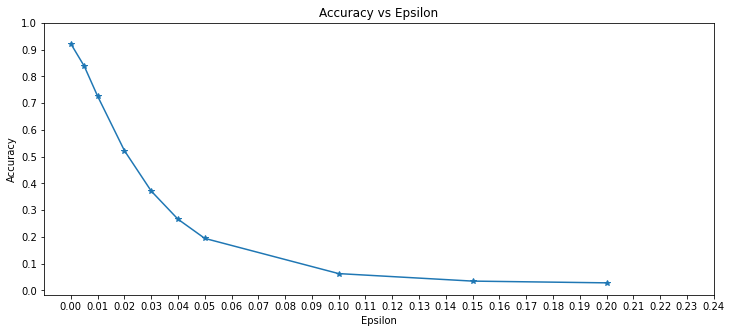

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .25, step=0.01))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

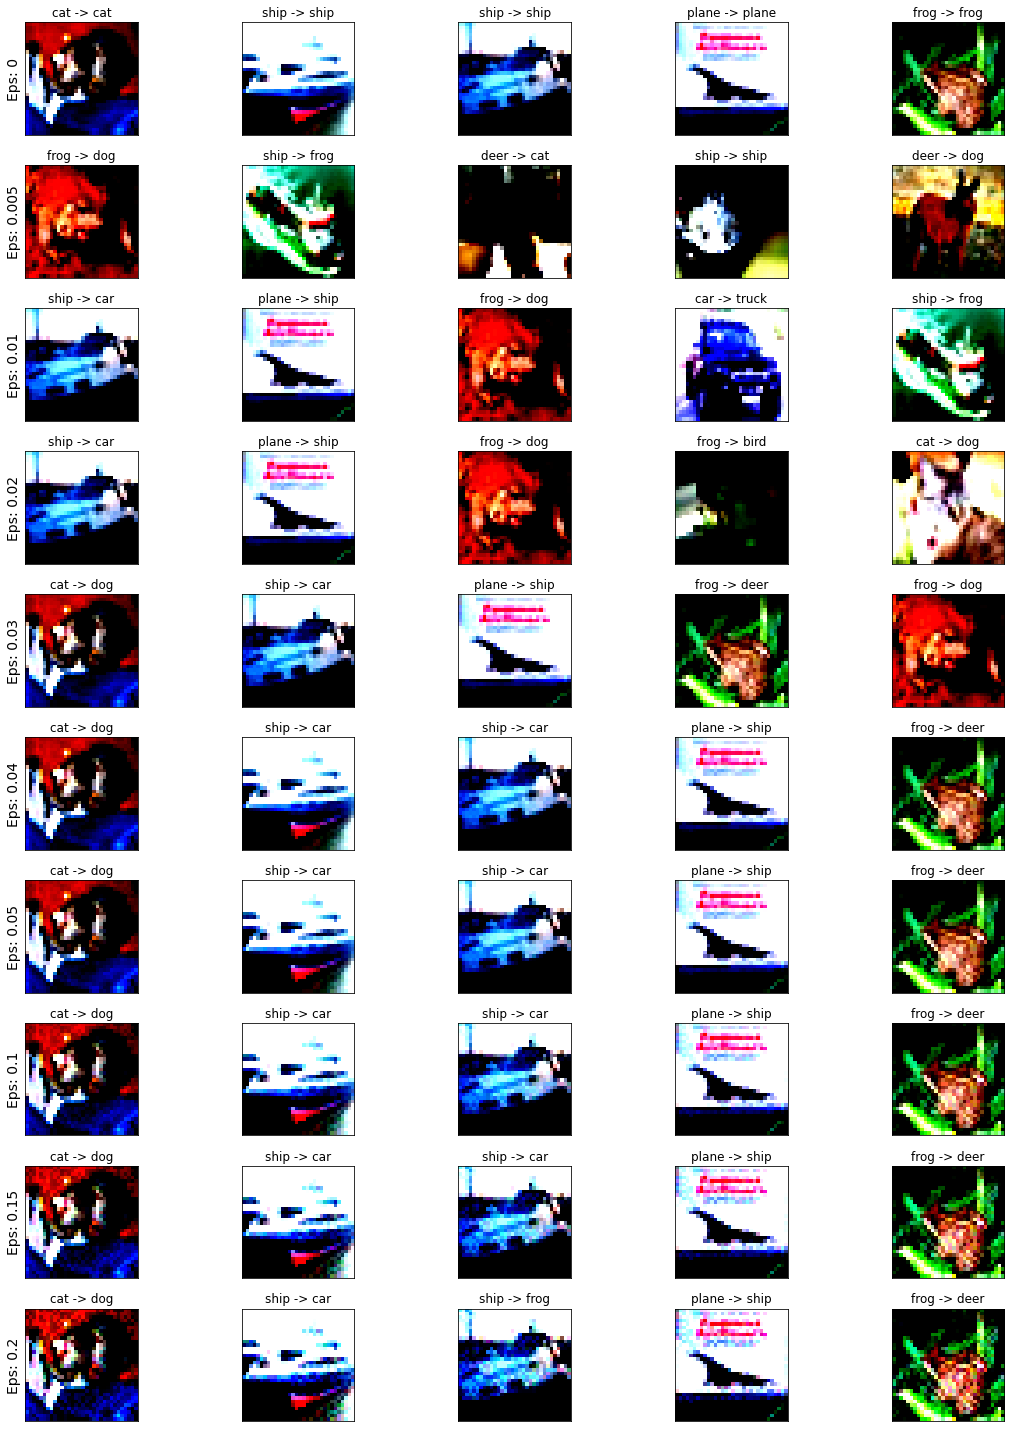

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(16, 20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(classes[orig], classes[adv]))
        plt.imshow(ex.transpose(1, 2, 0))
plt.tight_layout()
plt.show()

# Defense

In [46]:
def adv_train(net, criterion, optimizer, scheduler, trainloader, testloader, num_epoches, epsilon):
    for epoch in range(num_epoches):  # loop over the dataset multiple times

        normal_loss = 0.0
        adversarial_loss = 0.0
        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Set requires_grad attribute of tensor. Important for Attack
            inputs.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * 0.5
            normal_loss += loss.item()

            # Collect datagrad
            input_grad = inputs.grad.data

            # adversarial samples
            perturbed_data = fgsm_attack(inputs, epsilon, input_grad)
            yp = net(perturbed_data)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            loss = criterion(yp, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            adversarial_loss += loss.item()
            running_loss += loss.item() * 0.5
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f, normal loss: %.3f, adversarial loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000, normal_loss / 2000, adversarial_loss / 2000))
                running_loss = 0.0
                normal_loss = 0.0
                adversarial_loss = 0.0
    
        test_loss, test_acc = eval_epoch(net, testloader, criterion)
        test(net, criterion, testloader, epsilon)
        scheduler.step(test_loss)
        # pathname = "gdrive/My Drive/18-786 IDL/Project/defense/Model_"+str(datetime.now())+"_"+str(epoch) + ".pth"
        save_model(net, epoch, optimizer, scheduler)

    print('Finished Training')

## Train

In [56]:
adv_net = VGG('VGG16').to(device)
adv_criterion = nn.CrossEntropyLoss()
adv_optimizer = optim.Adam(net.parameters(), lr=1e-4)
adv_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
adv_train(adv_net, adv_criterion, adv_optimizer, adv_scheduler, trainloader, testloader, 50, 0.05)

[1,  2000] loss: 3.277, normal loss: 2.544, adversarial loss: 4.010
[1,  4000] loss: 3.269, normal loss: 2.536, adversarial loss: 4.002


## Attack

In [ ]:
test(net, criterion, testloader, 0.05)